In [348]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score

### Define static parameters for data

In [144]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
per_par=True
seq_len=3
step=3
test_doc_num = 10
n_splits = 3
seed=42
cv_db = pd.DataFrame()

### Define test documents

In [117]:
imp.reload(model_utils)
x=np.arange(1,81)
cv_splits=model_utils.get_test_train_splits(x,test_doc_num,n_splits,seed)
cv_splits

{0: {'test': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76]),
  'train': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 22,
         23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
         40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60,
         61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78,
         79, 80])},
 1: {'test': array([ 6,  8, 14, 19, 35, 36, 45, 60, 65, 69]),
  'train': array([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40,
         41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78,
         79, 80])},
 2: {'test': array([24, 25, 28, 34, 37, 40, 44, 49, 54, 77]),
  'train': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 3

In [218]:
cv_splits

{0: {'test': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76]),
  'train': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 22,
         23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
         40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60,
         61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78,
         79, 80])},
 1: {'test': array([ 6,  8, 14, 19, 35, 36, 45, 60, 65, 69]),
  'train': array([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40,
         41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78,
         79, 80])},
 2: {'test': array([24, 25, 28, 34, 37, 40, 44, 49, 54, 77]),
  'train': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 3

In [367]:
cv_splits_10=model_utils.get_test_train_splits(x,8,10,seed)
cv_splits_10

{0: {'test': array([ 4, 14, 15, 18, 29, 32, 36, 70]),
  'train': array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41,
         42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76,
         77, 78, 79, 80])},
 1: {'test': array([ 5,  6, 13, 34, 37, 62, 73, 80]),
  'train': array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39,
         40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
         57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75,
         76, 77, 78, 79])},
 2: {'test': array([ 7, 20, 39, 47, 48, 54, 57, 58]),
  'train': array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

In [156]:
imp.reload(common_utils)
cv_splits
common_utils.save_json(cv_splits,dir_name,"cv_splits")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits.json


### Load docs_map

In [44]:
imp.reload(common_utils)
docs_map=common_utils.get_docs_map(dir_name,docs_map_name,per_par,seq_len,step)

In [46]:
docs_map[1].keys()

dict_keys(['X_3_3', 'y_3_3', 'groups_3_3', 'X_bert', 'y_bert'])

### Cross-validate CRF

#### Load best CRF params

In [157]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,crf_params_name)
with open(json_path,'r') as fp:
    best_params_crf = json.load(fp)
best_params_crf

{'c1': 0.5850178031143265, 'c2': 0.052554161623508414, 'min_freq': 3}

In [158]:
imp.reload(model_utils)
cv_db_crf=model_utils.prepared_cross_validate_crf(cv_db,docs_map, cv_splits, seq_len=3, step=3,**best_params_crf)

0 split started...
0 split fit took 16.83 sec
0 split predict took 0.41 sec
1 split started...
1 split fit took 15.72 sec
1 split predict took 0.44 sec
2 split started...
2 split fit took 17.12 sec
2 split predict took 0.35 sec


In [352]:
crf = CRF()
crf.__class__.__name__


'CRF'

In [159]:
cv_db_crf

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,1,0,not_nar,not_nar,0.927267,0.072733
1,1,0,not_nar,not_nar,0.970439,0.029561
2,1,0,not_nar,not_nar,0.984975,0.015025
3,1,0,not_nar,not_nar,0.840957,0.159043
4,1,0,not_nar,not_nar,0.860823,0.139177
...,...,...,...,...,...,...
14585,77,2,not_nar,not_nar,0.980402,0.019598
14586,77,2,not_nar,not_nar,0.984651,0.015349
14587,77,2,not_nar,not_nar,0.974347,0.025653
14588,77,2,not_nar,not_nar,0.975137,0.024863


In [106]:
cv_db_crf['crf_group'].unique()

array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
       60, 65, 69, 24, 25, 28, 34, 37, 40, 44, 49, 54, 77])

Split 0
              precision    recall  f1-score   support

      is_nar       0.72      0.55      0.62      1697
     not_nar       0.80      0.89      0.84      3354

    accuracy                           0.78      5051
   macro avg       0.76      0.72      0.73      5051
weighted avg       0.77      0.78      0.77      5051

Split 1
              precision    recall  f1-score   support

      is_nar       0.56      0.52      0.54      1158
     not_nar       0.87      0.88      0.88      4088

    accuracy                           0.80      5246
   macro avg       0.71      0.70      0.71      5246
weighted avg       0.80      0.80      0.80      5246

Split 2
              precision    recall  f1-score   support

      is_nar       0.55      0.41      0.47       972
     not_nar       0.84      0.90      0.87      3321

    accuracy                           0.79      4293
   macro avg       0.69      0.65      0.67      4293
weighted avg       0.77      0.79      0.78      4

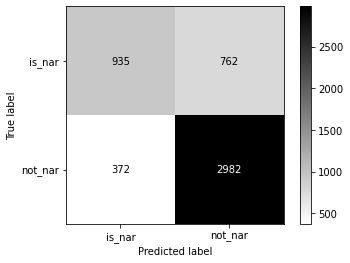

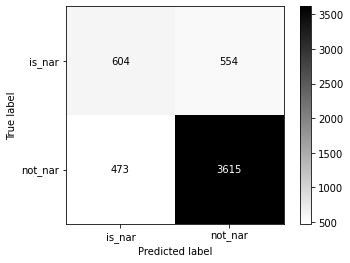

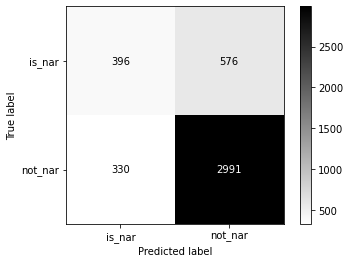

In [160]:
imp.reload(model_utils)
model_utils.get_report_from_splits(cv_db_crf,"crf")

In [161]:
common_utils.save_db(cv_db_crf,dir_name,"cv_crf")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_crf.csv,  index False


### Cross-validate BERT

In [118]:
imp.reload(my_bert)
bert_cv=pd.DataFrame()
cv_db_bert=my_bert.prepared_cross_validate_bert(bert_cv,docs_map, cv_splits)

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


BertXYTransformer>>>>>>>init() called
0 split started...
BertXYTransformer>>>>>>>transform() called for 70 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 33730 samples, labels are [0. 1.]
BertXYTransformer>>>>>>>transform() called for 10 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 5051 samples, labels are [0. 1.]
BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.66371507 2.02704327]

 Epoch 1 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.9291, -0.5024],
        [-0.3347, -1.2573],
        [-0.4534, -1.0092],
        ...,
        [-0.4234, -1.0636],
        [-0.6264, -0.7647],
        [-0.3347, -1.2573]])
Saving best model bert

Training Loss: 0.670

Validation Loss: 0.660

 Epoch 2 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.8668, -0.5452],
        [-0.2394, -1.5469],
        [-0.2833, -1.3996],
        ...,
        [-0.2906, -1.3777],
        [-0.3340, -1.2591],
 

train_validate() raw_preds tensor([[-0.0661, -2.7488],
        [-0.0661, -2.7488],
        [-0.0263, -3.6512],
        ...,
        [-0.0275, -3.6072],
        [-0.0395, -3.2506],
        [-0.0296, -3.5357]])

Training Loss: 0.263

Validation Loss: 0.179

 Epoch 5 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0739, -2.6416],
        [-0.0739, -2.6416],
        [-0.0233, -3.7713],
        ...,
        [-0.0243, -3.7283],
        [-0.0279, -3.5928],
        [-0.0258, -3.6699]])

Training Loss: 0.248

Validation Loss: 0.181

 Epoch 6 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0699, -2.6949],
        [-0.0699, -2.6949],
        [-0.0201, -3.9147],
        ...,
        [-0.0212, -3.8663],
        [-0.0238, -3.7514],
        [-0.0222, -3.8203]])

Training Loss: 0.240

Validation Loss: 0.187

 Epoch 7 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0637, -2.7849],
        [-0.0637, -2.7849],
        [-0.0173, -4.0653],
        ...,
        [-0.0180, -4.

In [365]:
import time
time.strftime("%H:%M:%S", time.gmtime(9622.53))

'02:40:22'

In [119]:
cv_db_bert

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,1,0,0,0,0.526763,0.473237
1,1,0,0,0,0.782847,0.217153
2,1,0,0,0,0.791494,0.208506
3,1,0,0,0,0.674561,0.325439
4,1,0,0,0,0.527963,0.472037
...,...,...,...,...,...,...
14585,77,2,0,0,0.713230,0.286770
14586,77,2,0,0,0.945393,0.054607
14587,77,2,0,0,0.953558,0.046442
14588,77,2,0,0,0.939007,0.060993


In [123]:
imp.reload(common_utils)
common_utils.save_db(cv_db_bert,dir_name,"cv_bert")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_bert.csv,  index False


Split 0
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      3354
           1       0.67      0.45      0.54      1697

    accuracy                           0.74      5051
   macro avg       0.72      0.67      0.68      5051
weighted avg       0.73      0.74      0.73      5051

Split 1
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4088
           1       0.72      0.75      0.73      1158

    accuracy                           0.88      5246
   macro avg       0.82      0.83      0.83      5246
weighted avg       0.88      0.88      0.88      5246

Split 2
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3321
           1       0.86      0.92      0.89       972

    accuracy                           0.95      4293
   macro avg       0.92      0.94      0.93      4293
weighted avg       0.95      0.95      0.95      4

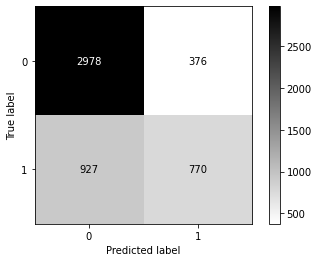

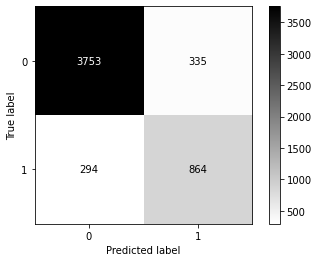

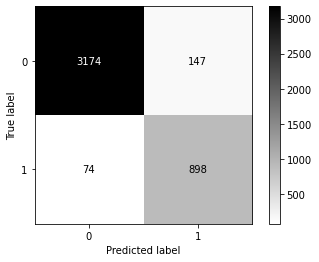

In [124]:
model_utils.get_report_from_splits(cv_db_bert,"bert")

### Merge BERT and CRF predictions

In [162]:
doc_size_db=pd.DataFrame()
doc_size_db['crf']=cv_db_crf.groupby('crf_group').size()
doc_size_db['bert']=cv_db_bert.groupby('bert_group').size()
doc_size_db

,crf,bert
crf_group,,
1,613,613
6,810,810
8,399,399
12,741,741
13,750,750
14,668,668
19,353,353
20,426,426
21,585,585


In [133]:
cv_db_crf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crf_group      14590 non-null  int64  
 1   crf_split      14590 non-null  int64  
 2   crf_predicted  14590 non-null  object 
 3   crf_true       14590 non-null  object 
 4   crf_proba_0    14590 non-null  float64
 5   crf_proba_1    14590 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 684.0+ KB


In [131]:
cv_db_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bert_group      14590 non-null  int64  
 1   bert_split      14590 non-null  int64  
 2   bert_predicted  14590 non-null  int64  
 3   bert_true       14590 non-null  int64  
 4   bert_proba_0    14590 non-null  float32
 5   bert_proba_1    14590 non-null  float32
dtypes: float32(2), int64(4)
memory usage: 570.0 KB


In [163]:
merged_cv_db=pd.merge(cv_db_crf,cv_db_bert,left_index=True,right_index=True,validate='one_to_one')
merged_cv_db

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,1,0,not_nar,not_nar,0.927267,0.072733,1,0,0,0,0.526763,0.473237
1,1,0,not_nar,not_nar,0.970439,0.029561,1,0,0,0,0.782847,0.217153
2,1,0,not_nar,not_nar,0.984975,0.015025,1,0,0,0,0.791494,0.208506
3,1,0,not_nar,not_nar,0.840957,0.159043,1,0,0,0,0.674561,0.325439
4,1,0,not_nar,not_nar,0.860823,0.139177,1,0,0,0,0.527963,0.472037
...,...,...,...,...,...,...,...,...,...,...,...,...
14585,77,2,not_nar,not_nar,0.980402,0.019598,77,2,0,0,0.713230,0.286770
14586,77,2,not_nar,not_nar,0.984651,0.015349,77,2,0,0,0.945393,0.054607
14587,77,2,not_nar,not_nar,0.974347,0.025653,77,2,0,0,0.953558,0.046442
14588,77,2,not_nar,not_nar,0.975137,0.024863,77,2,0,0,0.939007,0.060993


### Check that merge is correct

In [185]:
neg_label='not_nar'
merged_cv_db.query('crf_true==@neg_label and bert_true==1')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


In [187]:
neg_label='not_nar'
merged_cv_db.query('crf_group!=bert_group')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


### Run classifier on inputs from BERT and CRF proba

In [173]:
from sklearn.linear_model import LogisticRegression
X_train=merged_cv_db[merged_cv_db['crf_split'].isin([0,1])][['crf_proba_0','crf_proba_1','bert_proba_0','bert_proba_1']]
y_train=merged_cv_db[merged_cv_db['crf_split'].isin([0,1])]['bert_true']
X_test=merged_cv_db[merged_cv_db['crf_split'].isin([2])][['crf_proba_0','crf_proba_1','bert_proba_0','bert_proba_1']]
y_test=merged_cv_db[merged_cv_db['crf_split'].isin([2])]['bert_true']
X_train.head(),y_train.head()

(   crf_proba_0  crf_proba_1  bert_proba_0  bert_proba_1
 0     0.927267     0.072733      0.526763      0.473237
 1     0.970439     0.029561      0.782847      0.217153
 2     0.984975     0.015025      0.791494      0.208506
 3     0.840957     0.159043      0.674561      0.325439
 4     0.860823     0.139177      0.527963      0.472037,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: bert_true, dtype: int64)

In [175]:
lr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
lr_clf_pred=lr_clf.predict(X_test)

In [176]:
lr_clf.classes_

array([0, 1])

In [178]:
lr_clf.coef_

array([[-1.15513374,  1.14935738, -2.06329758,  2.05752122]])

CRF + BERT Logistic regression
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3321
           1       0.88      0.92      0.90       972

    accuracy                           0.95      4293
   macro avg       0.93      0.94      0.93      4293
weighted avg       0.95      0.95      0.95      4293



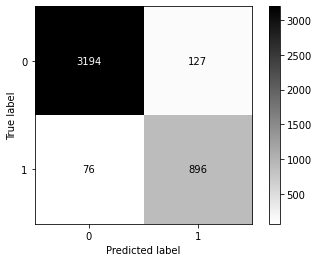

In [177]:
feature_utils.get_prediction_report(y_test,lr_clf_pred,lr_clf.classes_,"CRF + BERT Logistic regression")

### Implement cross-validate on ensemble

### Check what documents included in merged_cv_db

In [335]:
merged_cv_db[merged_cv_db['crf_group'].isin(cv_splits[0]['train'])]

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
5051,6,1,not_nar,not_nar,0.821621,0.178379,6,1,0,0,0.898004,0.101996
5052,6,1,not_nar,not_nar,0.829427,0.170573,6,1,0,0,0.813328,0.186673
5053,6,1,not_nar,not_nar,0.850742,0.149258,6,1,0,0,0.902851,0.097149
5054,6,1,not_nar,not_nar,0.674174,0.325826,6,1,0,0,0.922566,0.077434
5055,6,1,not_nar,not_nar,0.647519,0.352481,6,1,0,0,0.897437,0.102563
...,...,...,...,...,...,...,...,...,...,...,...,...
14585,77,2,not_nar,not_nar,0.980402,0.019598,77,2,0,0,0.713230,0.286770
14586,77,2,not_nar,not_nar,0.984651,0.015349,77,2,0,0,0.945393,0.054607
14587,77,2,not_nar,not_nar,0.974347,0.025653,77,2,0,0,0.953558,0.046442
14588,77,2,not_nar,not_nar,0.975137,0.024863,77,2,0,0,0.939007,0.060993


In [336]:
merged_cv_db['crf_group'].unique()

array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
       60, 65, 69, 24, 25, 28, 34, 37, 40, 44, 49, 54, 77])

In [337]:
ensembled_doc_num=len(merged_cv_db['crf_group'].unique())
ensembled_doc_num

30

In [338]:
ensemble_test_percent=0.125
n_splits=3
test_doc_num=int(ensemble_test_percent*ensembled_doc_num)
test_doc_num

3

In [339]:
ensemble_cv=model_utils.get_test_train_splits(merged_cv_db['crf_group'].unique(),test_doc_num,n_splits,seed)
ensemble_cv

{0: {'test': array([ 1, 35, 54]),
  'train': array([12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 77])},
 1: {'test': array([59, 14, 77]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 76,  6,  8, 19, 35, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 54])},
 2: {'test': array([60, 69, 25]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
         65, 24, 28, 34, 37, 40, 44, 49, 54, 77])}}

In [343]:
merged_cv_db.head()

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,1,0,not_nar,not_nar,0.927267,0.072733,1,0,0,0,0.526763,0.473237
1,1,0,not_nar,not_nar,0.970439,0.029561,1,0,0,0,0.782847,0.217153
2,1,0,not_nar,not_nar,0.984975,0.015025,1,0,0,0,0.791494,0.208506
3,1,0,not_nar,not_nar,0.840957,0.159043,1,0,0,0,0.674561,0.325439
4,1,0,not_nar,not_nar,0.860823,0.139177,1,0,0,0,0.527963,0.472037


In [240]:
common_utils.save_db(merged_cv_db,dir_name,'cv_crf_bert')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_crf_bert.csv,  index False


### Cross-validate ensemble by LogisticRegression

In [354]:
imp.reload(model_utils)
ensemble_cv_db=pd.DataFrame()
ensemble_cv_db=model_utils.prepared_cross_validate_ensemble(LogisticRegression(random_state=0),ensemble_cv_db,merged_cv_db,ensemble_cv)

0 split started...
train: [12 13 20 21 41 46 55 59 76  6  8 14 19 36 45 60 65 69 24 25 28 34 37 40
 44 49 77]
test: [ 1 35 54]
1 split started...
train: [ 1 12 13 20 21 41 46 55 76  6  8 19 35 36 45 60 65 69 24 25 28 34 37 40
 44 49 54]
test: [59 14 77]
2 split started...
train: [ 1 12 13 20 21 41 46 55 59 76  6  8 14 19 35 36 45 65 24 28 34 37 40 44
 49 54 77]
test: [60 69 25]


In [355]:
ensemble_cv_db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,0,0.756677,0.243323,1,0,0
1,0,0.924214,0.075786,1,0,0
2,0,0.929331,0.070669,1,0,0
3,0,0.842123,0.157877,1,0,0
4,0,0.729422,0.270578,1,0,0
...,...,...,...,...,...,...
5325,1,0.183473,0.816527,25,2,0
5326,0,0.956189,0.043811,25,2,0
5327,0,0.959509,0.040491,25,2,0
5328,0,0.953217,0.046783,25,2,0


Split 0
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1172
           1       0.77      0.64      0.70       476

    accuracy                           0.84      1648
   macro avg       0.82      0.78      0.80      1648
weighted avg       0.84      0.84      0.84      1648

Split 1
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1465
           1       0.65      0.67      0.66       306

    accuracy                           0.88      1771
   macro avg       0.79      0.80      0.79      1771
weighted avg       0.88      0.88      0.88      1771

Split 2
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1463
           1       0.70      0.73      0.71       448

    accuracy                           0.86      1911
   macro avg       0.81      0.81      0.81      1911
weighted avg       0.86      0.86      0.86      1

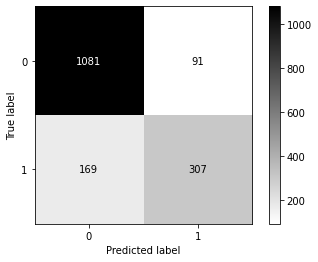

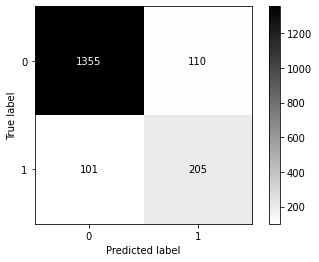

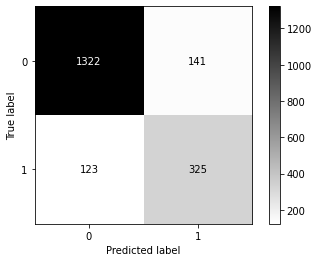

In [356]:
model_utils.get_report_from_splits(ensemble_cv_db,"ens")

### Cross-validate ensemble by CRF

In [357]:
ensemble_cv

{0: {'test': array([ 1, 35, 54]),
  'train': array([12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 77])},
 1: {'test': array([59, 14, 77]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 76,  6,  8, 19, 35, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 54])},
 2: {'test': array([60, 69, 25]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
         65, 24, 28, 34, 37, 40, 44, 49, 54, 77])}}

In [321]:
ens_crf = CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
)

In [362]:
imp.reload(model_utils)
ensemble_crf_cv_db=pd.DataFrame()
ensemble_crf_cv_db=model_utils.prepared_cross_validate_ensemble(
   CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
        ),ensemble_crf_cv_db,merged_cv_db,ensemble_cv,docs_map)

0 split started...
train: [12 13 20 21 41 46 55 59 76  6  8 14 19 36 45 60 65 69 24 25 28 34 37 40
 44 49 77]
test: [ 1 35 54]
1 split started...
train: [ 1 12 13 20 21 41 46 55 76  6  8 19 35 36 45 60 65 69 24 25 28 34 37 40
 44 49 54]
test: [59 14 77]
2 split started...
train: [ 1 12 13 20 21 41 46 55 59 76  6  8 14 19 35 36 45 65 24 28 34 37 40 44
 49 54 77]
test: [60 69 25]


In [363]:
ensemble_crf_cv_db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,not_nar,0.933737,0.066263,1,0,not_nar
1,not_nar,0.942903,0.057097,1,0,not_nar
2,not_nar,0.943635,0.056365,1,0,not_nar
3,not_nar,0.920161,0.079839,1,0,not_nar
4,not_nar,0.913397,0.086603,1,0,not_nar
...,...,...,...,...,...,...
5325,not_nar,0.950438,0.049562,25,2,not_nar
5326,not_nar,0.982397,0.017603,25,2,not_nar
5327,not_nar,0.991963,0.008037,25,2,not_nar
5328,not_nar,0.993295,0.006705,25,2,not_nar


Split 0
              precision    recall  f1-score   support

      is_nar       0.80      0.75      0.77       476
     not_nar       0.90      0.92      0.91      1172

    accuracy                           0.87      1648
   macro avg       0.85      0.84      0.84      1648
weighted avg       0.87      0.87      0.87      1648

Split 1
              precision    recall  f1-score   support

      is_nar       0.75      0.70      0.72       306
     not_nar       0.94      0.95      0.94      1465

    accuracy                           0.91      1771
   macro avg       0.85      0.82      0.83      1771
weighted avg       0.91      0.91      0.91      1771

Split 2
              precision    recall  f1-score   support

      is_nar       0.80      0.82      0.81       448
     not_nar       0.94      0.94      0.94      1463

    accuracy                           0.91      1911
   macro avg       0.87      0.88      0.87      1911
weighted avg       0.91      0.91      0.91      1

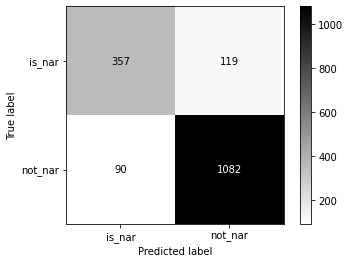

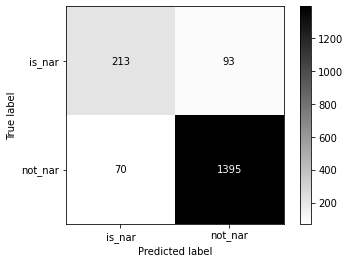

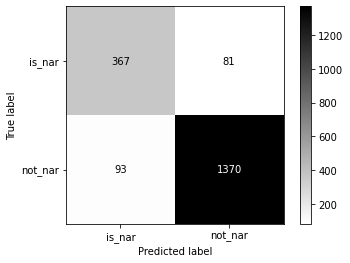

In [364]:
model_utils.get_report_from_splits(ensemble_crf_cv_db,"ens")

In [349]:
sequence_accuracy_score(y_test,ens_crf_pred)

0.872865275142315